# Predicting US Median Price of Houses Sold

## Goal

The goal of this project is to predict median US house sale prices using the FRED (Federal Reserve Economic Data) timeseries API and Python implementations of machine learning models

## Summary

This README provides an overview of the process to fetch and explore data from the FRED timeseries API and use Python for predictive modeling. The outlined steps will guide you through the process of data retrieval, exploration, and implementation of machine learning models for predicting median US house sales prices.

### Authors

- Joshua Lee
- Evan Grillo

### Python Imports

In [1]:
import pandas as pd
import seaborn as sns
import shap
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pyplot 

from dotenv import load_dotenv
import os
load_dotenv()

from fredapi import Fred

#SKLEARN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoost
import xgboost as xgb

#Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

2024-02-20 20:18:27.950316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create instance of the FRED Python wrapper with an environment variable

Generate an API key with FRED [FRED API Key](https://fredaccount.stlouisfed.org/apikeys)

PyPi project for Python FRED wrapper [fredapi](https://pypi.org/project/fredapi/)


In [2]:
# env variable
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

# Fetching &amp; Processing Data 

The `fred_timeseries_mapping` dictionary serves as a mapping between FRED (Federal Reserve Economic Data) timeseries API codes and their corresponding names.

Each timeseries in this mapping represents economic indicators, with reporting frequencies ranging from quarterly through the current week.

## Process Overview

1. **Data Retrieval:**
   - The `fred_timeseries_mapping` is a dictionary containing FRED timeseries API codes as keys and their corresponding names as values.

2. **Data Collection:**
   - We initialize a list to store data frames. Iterating through the dictionary, we request each timeseries code and group the data by the year and quarter. This grouping ensures that the index for each series aligns, accommodating inconsistent reporting frequencies.

3. **DataFrame Construction:**
   - After iterating through the dictionary, we create a main dataframe by concatenating the list of dataframes. The FRED Python wrapper facilitates this process by building HTTP URLs and handling tasks like processing datetime data, setting it as the index.

4. **Handling Missing Data:**
   - We use the `dropna` function to remove any missing data points, ensuring a clean and complete dataset.

This initialization process lays the foundation for subsequent data analysis and machine learning tasks. The resulting dataframe is ready for feature engineering, model training, and predictive analytics.


In [3]:
# FRED timeseries API map dictionary
fred_timeseries_mapping = {
    'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
    'HOUST': 'New Privately-Owned Housing Units Started: Total Units',
    'CSUSHPINSA': 'S&P CoreLogic Case-Shiller U.S. National Home Price Index',
    'HPIPONM226S': 'Purchase Only House Price Index for the United States',
    'ETOTALUSQ176N': 'Housing Inventory Estimate: Total Housing Units in the United States',
    'USSTHPI': 'All-Transactions House Price Index for the United States',
    'WPUSI012011': 'Producer Price Index by Commodity: Special Indexes: Construction Materials',
    'ILSTHPI': 'All-Transactions House Price Index for Illinois',
    'MORTGAGE30US': '30-Year Fixed Rate Mortgage Average in the United States',
    'MORTGAGE15US': '15-Year Fixed Rate Mortgage Average in the United States',
    'MSACSR': 'Monthly Supply of New Houses in the United States',
    'MSPUS': 'Median Sales Price of Houses Sold for the United States'
}

start = "2000-01-01"
#end

dfs = []

for s in list(fred_timeseries_mapping.keys()):
    
    data = fred.get_series(s, observation_start=start)
    df = pd.DataFrame(data)

    df_grouped = df.groupby(by=[df.index.year, df.index.quarter]).mean() 
    dfs.append(df_grouped)
    
housing_data_df = pd.concat(dfs, axis=1)
housing_data_df.columns = list(fred_timeseries_mapping.keys())
housing_data_df.dropna(inplace=True)

display(housing_data_df.head(10))
display(housing_data_df.tail(10))

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   
     3  177.633333  1599.666667  114.893000   151.590000       118216.0   
     4  177.500000  1570.000000  115.858667   153.943333       118635.0   
2002 1  178.066667  1723.000000  117.094000   156.560000       119061.0   
     2  179.466667  1691.000000  120.776333   159.420000       119483.0   
     3  180.433333  1697.333333  124.636667   162.483333       119909.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333   
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667   
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333   
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667   
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333   
     3   255.85   143.233333   265.05      6.963846      6.506923  4.333333   
     4   259.02   142.033333   267.50      6.770769      6.253077  4.066667   
2002 1   262.73   142.466667   272.12      6.971538      6.461538  4.100000   
     2   267.21   143.866667   276.94      6.813077      6.286154  4.166667   
     3   272.51   145.066667   280.51      6.289231      5.712308  4.033333   

           MSPUS  
2000 2  163200.0  
     3  168800.0  
     4  172900.0  
2001 1  169800.0  
     2  179000.0  
     3  172500.0  
     4  171100.0  
2002 1  188700.0  
     2  187200.0  
     3  178100.0

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2021 2  268.622667  1581.666667  255.498000   333.000000       141927.0   
     3  272.890000  1576.333333  268.593000   348.133333       142288.0   
     4  278.680333  1690.333333  276.106667   361.763333       142697.0   
2022 1  284.826000  1717.666667  288.086000   377.643333       143105.0   
     2  291.706333  1635.666667  305.479000   390.660000       143514.0   
     3  295.509000  1446.333333  303.747333   390.126667       143923.0   
     4  298.441000  1405.333333  296.664000   391.553333       144332.0   
2023 1  301.203000  1385.333333  294.520000   394.996667       144740.0   
     2  303.466667  1449.666667  305.039667   403.173333       145149.0   
     3  306.034333  1370.666667  311.367333   412.006667       145558.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2021 2   510.74   304.466667   385.96      3.003846      2.309231  5.366667   
     3   539.20   314.587000   399.44      2.872143      2.171429  6.066667   
     4   557.79   328.697333   408.73      3.079231      2.338462  6.133333   
2022 1   578.36   345.059000   419.56      3.822308      3.044615  6.333333   
     2   617.03   348.867000   445.57      5.266154      4.450769  8.766667   
     3   627.42   342.002333   450.94      5.623077      4.880769  9.500000   
     4   622.78   330.204667   446.16      6.664615      5.959231  9.200000   
2023 1   625.78   329.866333   449.78      6.372308      5.564615  8.200000   
     2   645.38   336.058333   468.27      6.510769      5.870769  7.433333   
     3   657.32   333.468000   479.38      7.040000      6.396154  7.500000   

           MSPUS  
2021 2  382600.0  
     3  411200.0  
     4  423600.0  
2022 1  433100.0  
     2  449300.0  
     3  468000.0  
     4  479500.0  
2023 1  429000.0  
     2  418500.0  
     3  435400.0

In [4]:
list(fred_timeseries_mapping.keys())

['CPIAUCSL',
 'HOUST',
 'CSUSHPINSA',
 'HPIPONM226S',
 'ETOTALUSQ176N',
 'USSTHPI',
 'WPUSI012011',
 'ILSTHPI',
 'MORTGAGE30US',
 'MORTGAGE15US',
 'MSACSR',
 'MSPUS']

<Axes: >

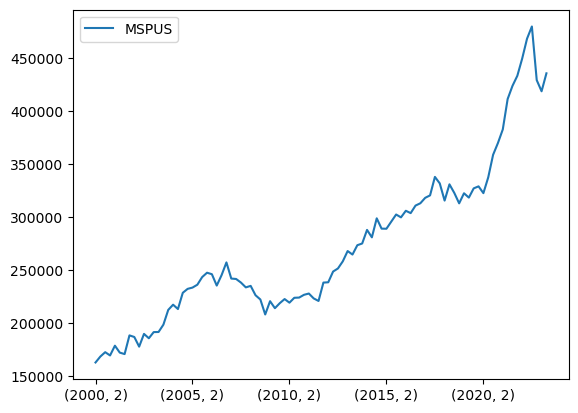

In [5]:
# Plot MSPUS series
housing_data_df[['MSPUS']].plot()

# Correlation Analysis

## Objective

The initial phase of this analysis aimed to investigate the predictive potential of using the feature MSACSR ('Monthly Supply of New Houses in the United States') to forecast MSPUS ('Median Sales Price of Houses Sold for the United States'). To enhance this exploration, additional timeseries from FRED were incorporated, considering potential correlations with the target variable, MSPUS.

## Methodology

1. **Feature Selection:**
   - The primary focus was on MSACSR as a potential predictor for MSPUS. Other timeseries from FRED were introduced to expand the set of features and capture potential correlations.

2. **Correlation Calculation:**
   - The analysis proceeded to calculate the correlation between the selected features and the target variable (MSPUS). The correlation values were then sorted from high to low.

3. **Visualization:**
   - To provide a clear representation of the correlation results, the sorted correlation values were visualized. This step aids in understanding the strength and direction of relationships between features and the target variable.

In [6]:
# Look at correlation between target and features
target_column = 'MSPUS'

# Calculate correlations for each series with the target
correlations = housing_data_df.copy() \
    .drop(columns=target_column) \
    .corrwith(housing_data_df[target_column]) \
    .abs() \
    .sort_values(ascending=False)

print(f'{correlations}\n\nFeature with highest correlation: {fred_timeseries_mapping[correlations.keys()[0]]}')

WPUSI012011      0.959855
HPIPONM226S      0.956565
CSUSHPINSA       0.955770
CPIAUCSL         0.949600
USSTHPI          0.946107
ETOTALUSQ176N    0.904010
ILSTHPI          0.805625
MORTGAGE15US     0.466533
MORTGAGE30US     0.453050
MSACSR           0.217826
HOUST            0.030514
dtype: float64

Feature with highest correlation: Producer Price Index by Commodity: Special Indexes: Construction Materials


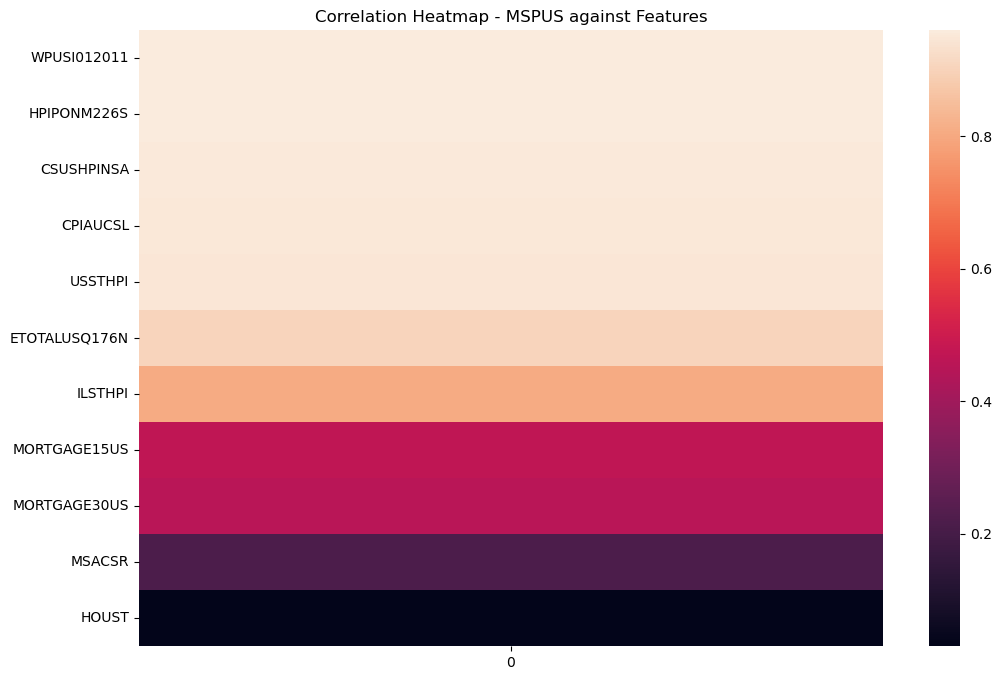

In [7]:
# Visualize correlation
features = housing_data_df.columns.drop('MSPUS')

correlation_matrix = housing_data_df[features].corrwith(housing_data_df['MSPUS']) \
    .abs() \
    .sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.to_frame())
plt.title(f"Correlation Heatmap - {'MSPUS'} against Features")
plt.show()

Notice that our key feature - Monthly Supply of New Houses in the United States - has the second lowest correlation with the target

## Determine if candidate for Simple Linear Regression

Find best fit line or linear equation that represents the relationship between MSACSR and MSPUS

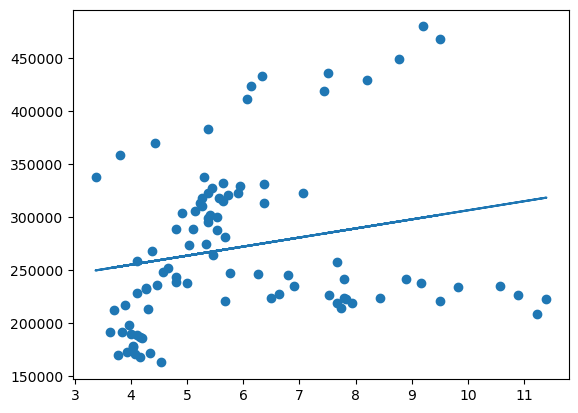

0.21782562588367504 Weak candidate for Linear Regression


In [8]:
# Set x & y feature
x_lr = housing_data_df['MSACSR']
y_lr = housing_data_df['MSPUS']

slope, intercept, r, p, std_err = stats.linregress(x_lr, y_lr)

plt.scatter(x_lr, y_lr)
plt.plot(x_lr, slope * x_lr + intercept)
plt.show()

if r > .8 or r < -.8:
    print(f'{r}: Good candidate for Linear Regression')
else:
    print(f'{r} Weak candidate for Linear Regression')

### What about linear regression using the feature with the highest correlation?

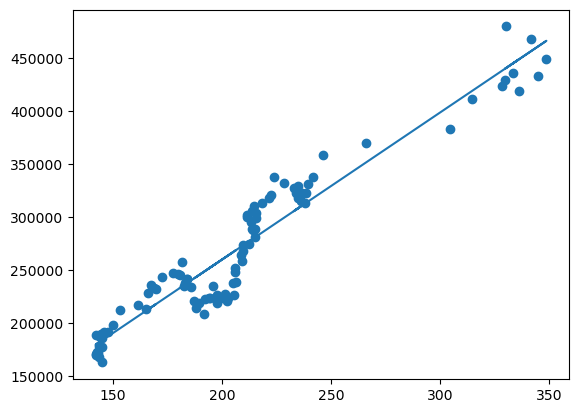

Producer Price Index by Commodity: Special Indexes: Construction Materials
0.9598553819094683: Good candidate for Linear Regression


In [9]:
# Set x & y feature
x_lr = housing_data_df[correlations.keys()[0]]
y_lr = housing_data_df['MSPUS']

slope, intercept, r, p, std_err = stats.linregress(x_lr, y_lr)

plt.scatter(x_lr, y_lr)
plt.plot(x_lr, slope * x_lr + intercept)
plt.show()

print(fred_timeseries_mapping[correlations.keys()[0]])
if r > .8 or r < -.8:
    print(f'{r}: Good candidate for Linear Regression')
else:
    print(f'{r} Weak candidate for Linear Regression')

## Determine if candidate for Polynomial Regression

Like linear regression, it seeks to find a 'best fit' line but can flex and bend to better match the data points

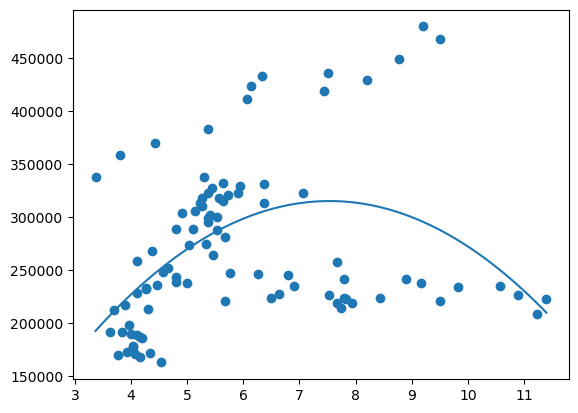

0.20093110642414314 Weak candidate for Polynomial Regression


In [10]:
#Polynomial Regression
x_pr = housing_data_df['MSACSR']
y_pr = housing_data_df['MSPUS']

mymodel = np.poly1d(np.polyfit(x_pr, y_pr, 2))
myline = np.linspace(min(x_pr), max(x_pr), 100)

plt.scatter(x_pr, y_pr)
plt.plot(myline, mymodel(myline))
plt.show()

r2s = r2_score(y_pr, mymodel(x_pr))

if r2s > 0.9:
    print(f'{r2s}: Good candidate for Polynomial Regression')
else:
    print(f'{r2s} Weak candidate for Polynomial Regression')

## What about polynomial regression using a feature with higher correlation to target?

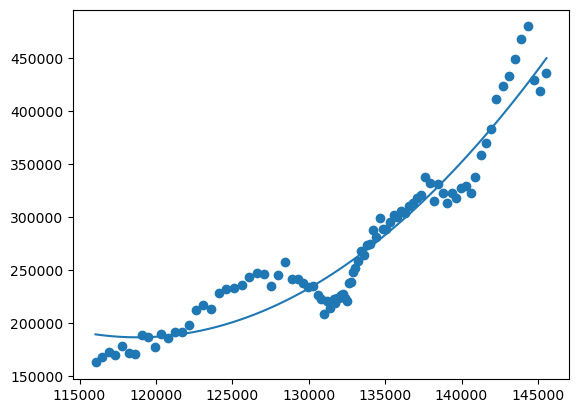

0.9175260720697915: Good candidate for Polynomial Regression


In [11]:
#Polynomial Regression
x_pr = housing_data_df['ETOTALUSQ176N']
y_pr = housing_data_df['MSPUS']

mymodel = np.poly1d(np.polyfit(x_pr, y_pr, 2))
myline = np.linspace(min(x_pr), max(x_pr), 100)

plt.scatter(x_pr, y_pr)
plt.plot(myline, mymodel(myline))
plt.show()

r2s = r2_score(y_pr, mymodel(x_pr))

if r2s > 0.9:
    print(f'{r2s}: Good candidate for Polynomial Regression')
else:
    print(f'{r2s} Weak candidate for Polynomial Regression')

### What does this correlation analysis suggest?

The feature that we're interested in using to make predictions (housing supply) is not highly correlated with the target. However, we also have features available that are highly correlated with the target, e.g. Producer Price Index by Commodity: Special Indexes: Construction Materials.

To successfully predict our target, we may need to implement models that can capture complex relationships that aren't linear or highly correlated.

### Implement Linear Regression Model &amp; Make Predictions

In [12]:
# Create X feature df
X = housing_data_df.copy().drop(columns='MSPUS')
X.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333  
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667  
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333  
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667  
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333

In [13]:
# Create y target df
y = housing_data_df[['MSPUS']]
y.head()

MSPUS
2000 2  163200.0
     3  168800.0
     4  172900.0
2001 1  169800.0
     2  179000.0

### Additional Data Handling

1. Split Test &amp; Train Data
2. Scale features to eliminate bias and equalize features

In [14]:
# To split test & train, calculate 80% of the index range, which represents number of years
split = round(abs(X.index.min()[0] - X.index.max()[0]) * 0.8)
split

18

In [15]:
# Slice data by date to split testing and training data

#Start
training_begin = X.index.min()[0]
training_end = X.index.min()[0] + split

display(training_begin)
display(training_end)

2000

2018

In [16]:
# Split the train data
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.tail()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2017 4  247.238333  1235.666667  195.461667   248.006667       137637.0   
2018 1  249.321667  1298.000000  197.195000   252.636667       137920.0   
     2  250.679000  1275.000000  202.370333   255.630000       138203.0   
     3  251.686333  1248.666667  205.216667   258.863333       138488.0   
     4  252.711000  1165.666667  205.056667   261.856667       138778.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  
2017 4   403.58   223.966667   335.72      3.922308      3.290769  5.300000  
2018 1   409.26   228.600000   337.40      4.282308      3.740000  5.633333  
     2   416.79   236.133333   339.57      4.544615      4.014615  5.633333  
     3   421.88   239.666667   340.73      4.566923      4.033846  6.366667  
     4   423.32   238.600000   340.14      4.784615      4.212308  7.066667

In [17]:
#Split the test data
X_test = X.loc[training_end+1:]
y_test = y.loc[training_end+1:]

X_test.isna().any()

CPIAUCSL         False
HOUST            False
CSUSHPINSA       False
HPIPONM226S      False
ETOTALUSQ176N    False
USSTHPI          False
WPUSI012011      False
ILSTHPI          False
MORTGAGE30US     False
MORTGAGE15US     False
MSACSR           False
dtype: bool

In [18]:
# Scale features

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Implement Multiple Linear Regression Model &amp; Make Predictions

In [19]:
model = LinearRegression() 
model.fit(X_train_scaled, y_train)

LinearRegression()

In [20]:
print(f"Model's slope: {model.coef_}") 

Model's slope: [[ 42759.08091435   9274.91954663  27859.70094362  30756.89883235
    8036.57513398 -39452.90801128 -14513.13516268  -7969.69006994
  -37900.60411618  38703.80724143   3136.83942133]]


In [21]:
predicted_y_values = model.predict(X_test_scaled) 

In [22]:
# Create a copy of the original data for a predictions DF
housing_predictions_df = housing_data_df.copy().loc[training_end+1:]

# Add a column with the predicted sales values
housing_predictions_df["MSPUS_lr_predicted"] = predicted_y_values

# Display sample data
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2019 1  253.385667  1185.000000  204.805333   265.070000       139069.0   
     2  255.247333  1267.333333  209.215000   268.286667       139360.0   
     3  256.089333  1304.000000  211.642667   271.656667       139655.0   
     4  257.888000  1409.666667  212.109667   276.390000       139961.0   
2020 1  258.767333  1468.000000  213.609333   281.653333       140266.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2019 1   428.05   238.233333   343.17      4.373846      3.815385  6.366667   
     2   435.20   236.933333   348.17      4.010769      3.464615  5.900000   
     3   440.74   234.800000   351.52      3.658462      3.129231  5.566667   
     4   444.66   232.933333   353.19      3.700000      3.157692  5.433333   
2020 1   449.81   234.766667   354.77      3.521538      2.983077  5.933333   

           MSPUS  MSPUS_lr_predicted  
2019 1  313000.0       338206.066520  
     2  322500.0       345529.091282  
     3  318400.0       350694.428748  
     4  327100.0       358373.820659  
2020 1  329000.0       364294.770102

<Axes: >

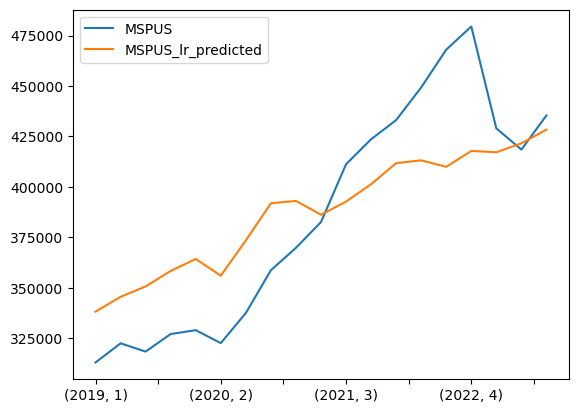

In [23]:
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted']].plot()

### Implement a DecisionTreeRegressor Model &amp; Make Predictions

A decision tree regressor is a model that makes decisions in a step-by-step manner, creating a tree-like structure based on the input features. At each step, it assesses a feature and branches recursively until it reaches a final prediction.

In [24]:
# Create a decision tree model
decision_tree_model = DecisionTreeRegressor(random_state=0)

# Train the model
decision_tree_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test_scaled)

# Evaluate the model
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print(f'Root Mean Squared Error: {rmse}')
housing_predictions_df["MSPUS_dt_predicted"] = y_pred

# Display feature importances
feature_importances = decision_tree_model.feature_importances_

print(f'\nFeature importances: \n')

feature_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


Root Mean Squared Error: 77442.19576051887

Feature importances: 

ETOTALUSQ176N: 0.7166553625995349
USSTHPI: 0.19164741339073973
HPIPONM226S: 0.041653806068258796
WPUSI012011: 0.021409197766554894
HOUST: 0.016722440140533028
CPIAUCSL: 0.004057698085005901
CSUSHPINSA: 0.003225625821121445
ILSTHPI: 0.0015369975810229134
MSACSR: 0.001491574674630293
MORTGAGE30US: 0.0011656218840575706
MORTGAGE15US: 0.00043426198854052577


<Axes: >

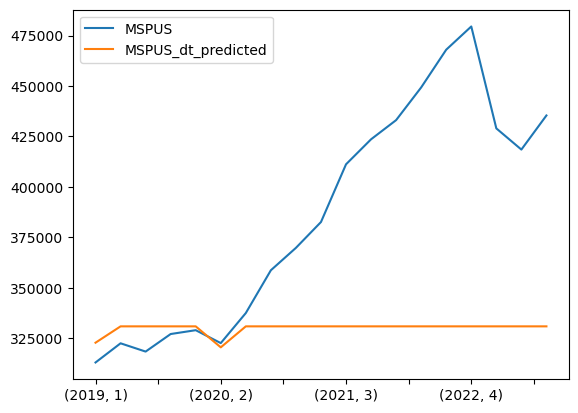

In [25]:
# Plot predictions
housing_predictions_df[['MSPUS', 'MSPUS_dt_predicted']].plot()

### Implement a RandomForestRegressor Model &amp; Make Predictions

A RandomForestRegressor is a model that operates similarly to a decision tree regressor but employs an ensemble of multiple trees. Each tree independently provides a prediction, and the final result is determined by averaging or taking the majority decision from these individual predictions.

In [26]:
# Create a Random Forest Regressor model
random_forest_model = RandomForestRegressor()

# Train the model
random_forest_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Squared Error: {rmse}')
housing_predictions_df["MSPUS_rfr_predicted"] = y_pred

# Display feature importances
feature_importances = random_forest_model.feature_importances_

print(f'\nFeature importances: \n')

feature_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

Mean Squared Error: 6392806268.263158

Feature importances: 

CPIAUCSL: 0.3045107158151699
ETOTALUSQ176N: 0.2907655918032435
WPUSI012011: 0.24851491980513288
USSTHPI: 0.051882547496458944
HPIPONM226S: 0.03777048683641331
ILSTHPI: 0.023612811773306586
HOUST: 0.022000994144804286
CSUSHPINSA: 0.01324430204630932
MORTGAGE30US: 0.002860327940334528
MORTGAGE15US: 0.002530407834222015
MSACSR: 0.0023068945046047294


<Axes: >

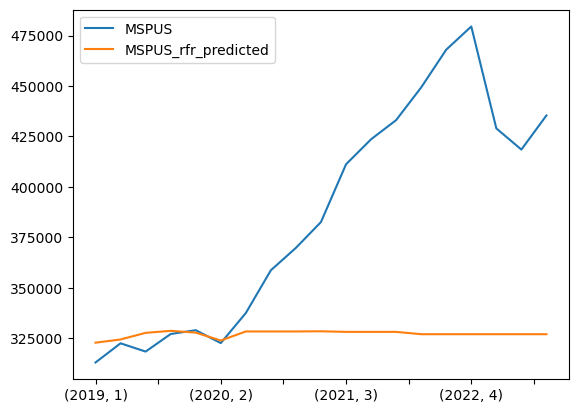

In [27]:
# Plot predictions
housing_predictions_df[['MSPUS', 'MSPUS_rfr_predicted']].plot()

### Implement a Sequential Model &amp; Make Predictions



In [28]:
model = Sequential()
number_inputs = len(X_train_scaled[0])
model.add(Dense(units=64, activation="relu", input_dim=number_inputs)) 
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [29]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)

# Transform test data using the same scaler
y_test_scaled = scaler.transform(y_test)
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

model.summary()

Epoch 1/50
2/2 [==============================] - 1s 171ms/step - loss: 0.1645 - val_loss: 0.3424
Epoch 2/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0853 - val_loss: 0.2578
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0547 - val_loss: 0.1897
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0375 - val_loss: 0.1366
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0268 - val_loss: 0.0950
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0203 - val_loss: 0.0665
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0198 - val_loss: 0.0479
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0197 - val_loss: 0.0376
Epoch 9/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0164 - val_loss: 0.0316
Epoch 10/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0132 - val_loss: 0.0284
Epoch 11/50
2/2 [===========

In [30]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_pred

1/1 [==============================] - 0s 99ms/step


array([[359716.22],
       [368685.1 ],
       [376457.5 ],
       [382531.56],
       [401450.34],
       [387514.25],
       [417702.78],
       [451515.25],
       [495876.12],
       [554487.  ],
       [595851.1 ],
       [625355.3 ],
       [657631.06],
       [729407.25],
       [727130.3 ],
       [725280.75],
       [722354.94],
       [739623.  ],
       [756639.94]], dtype=float32)

<Axes: >

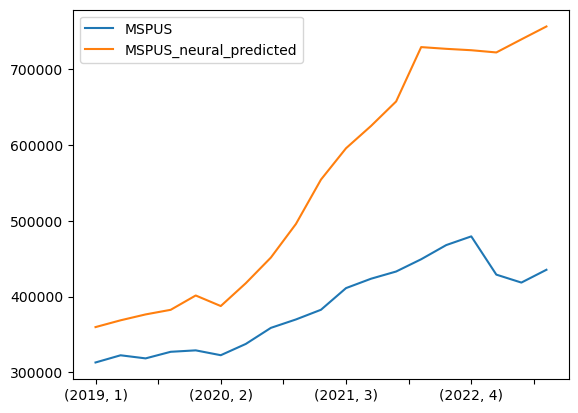

In [31]:
# Assign predictions to series & then plot
housing_predictions_df["MSPUS_neural_predicted"] = y_pred
housing_predictions_df[['MSPUS', 'MSPUS_neural_predicted']].plot()

In [32]:
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2019 1  253.385667  1185.000000  204.805333   265.070000       139069.0   
     2  255.247333  1267.333333  209.215000   268.286667       139360.0   
     3  256.089333  1304.000000  211.642667   271.656667       139655.0   
     4  257.888000  1409.666667  212.109667   276.390000       139961.0   
2020 1  258.767333  1468.000000  213.609333   281.653333       140266.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2019 1   428.05   238.233333   343.17      4.373846      3.815385  6.366667   
     2   435.20   236.933333   348.17      4.010769      3.464615  5.900000   
     3   440.74   234.800000   351.52      3.658462      3.129231  5.566667   
     4   444.66   232.933333   353.19      3.700000      3.157692  5.433333   
2020 1   449.81   234.766667   354.77      3.521538      2.983077  5.933333   

           MSPUS  MSPUS_lr_predicted  MSPUS_dt_predicted  MSPUS_rfr_predicted  \
2019 1  313000.0       338206.066520            322800.0             322807.0   
     2  322500.0       345529.091282            330900.0             324408.0   
     3  318400.0       350694.428748            330900.0             327682.0   
     4  327100.0       358373.820659            330900.0             328674.0   
2020 1  329000.0       364294.770102            330900.0             327805.0   

        MSPUS_neural_predicted  
2019 1            359716.21875  
     2            368685.09375  
     3            376457.50000  
     4            382531.56250  
2020 1            401450.34375

### Let's dig deeper into new models...

In [33]:
# Pass features data to the pool constructor
train_dataset = cb.Pool(X_train_scaled, y_train) 
test_dataset = cb.Pool(X_test_scaled, y_test)

In [34]:
# Create CatBoost model instance, using Root Mean Squared Error
model = cb.CatBoostRegressor(loss_function='RMSE')

In [35]:
# Create config for grid 
grid = {'iterations': [25, 50, 75],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 239632.9398108	test: 242550.2429084	best: 242550.2429084 (0)	total: 48.5ms	remaining: 1.16s
1:	learn: 232594.5634860	test: 235374.6361376	best: 235374.6361376 (1)	total: 48.9ms	remaining: 562ms
2:	learn: 225785.7709509	test: 228752.4495616	best: 228752.4495616 (2)	total: 49ms	remaining: 359ms
3:	learn: 219191.0675184	test: 221976.6201415	best: 221976.6201415 (3)	total: 49.1ms	remaining: 258ms
4:	learn: 212711.3753727	test: 215598.8129153	best: 215598.8129153 (4)	total: 49.2ms	remaining: 197ms
5:	learn: 206469.8983879	test: 209317.3073751	best: 209317.3073751 (5)	total: 49.3ms	remaining: 156ms
6:	learn: 200381.6534360	test: 203210.8767456	best: 203210.8767456 (6)	total: 49.8ms	remaining: 128ms
7:	learn: 194541.4665836	test: 197280.7614973	best: 197280.7614973 (7)	total: 50.2ms	remaining: 107ms
8:	learn: 188824.3749818	test: 191630.9722803	best: 191630.9722803 (8)	total: 50.4ms	remaining: 89.6ms
9:	learn: 183254.1721789	test: 185863.9121903	best: 185863.9121903 (9)	total: 50.9m

{'params': {'depth': 2,
  'iterations': 50,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [36]:
# Use cat boost to make predictions
pred = model.predict(X_test_scaled)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 90835.16
R2: -1.74


In [37]:
# Look at feature weights
feature_importances = model.feature_importances_
feature_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

ETOTALUSQ176N: 21.604131545913518
MORTGAGE15US: 19.142213181800276
CPIAUCSL: 16.570316915032535
WPUSI012011: 12.53259567778155
USSTHPI: 9.661128969968367
HPIPONM226S: 6.562755106754101
ILSTHPI: 4.1716996723394555
MSACSR: 3.791284009691252
CSUSHPINSA: 3.191888043456197
HOUST: 2.529455786809906
MORTGAGE30US: 0.24253109045284663


<Axes: >

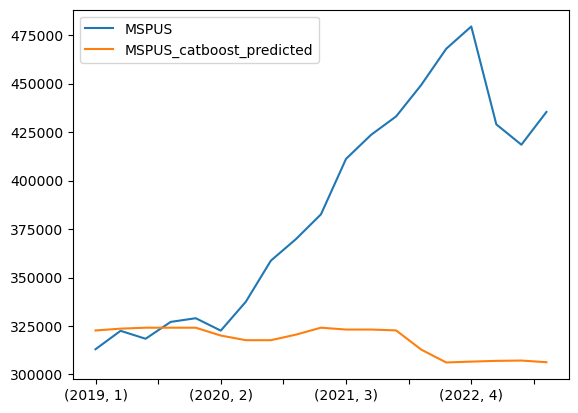

In [38]:
# Assign and plot predictions
housing_predictions_df['MSPUS_catboost_predicted'] = pred
housing_predictions_df[['MSPUS', 'MSPUS_catboost_predicted']].plot()

In [39]:
# Create XGB model and fit training data
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_scaled, y_train, verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

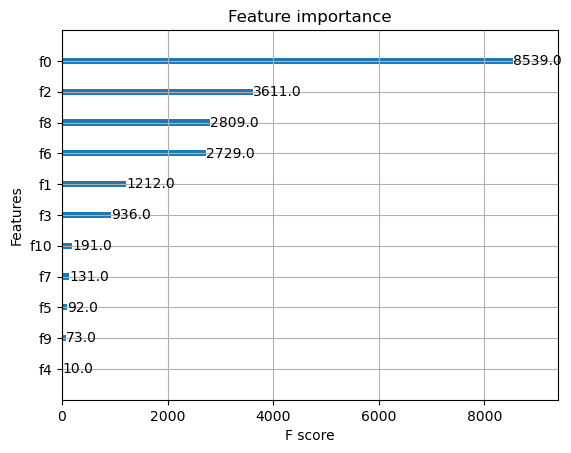

In [40]:
# Plot feature weights
xgb.plot_importance(reg)

<Axes: >

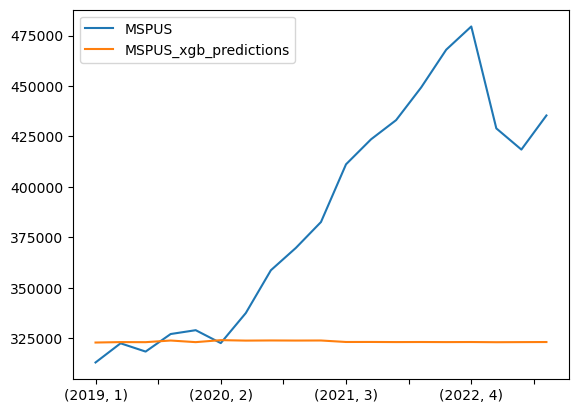

In [41]:
# Make predictions, then assign and plot them
predictions = reg.predict(X_test_scaled)
housing_predictions_df['MSPUS_xgb_predictions'] = predictions
housing_predictions_df[['MSPUS', 'MSPUS_xgb_predictions']].plot()

<Axes: >

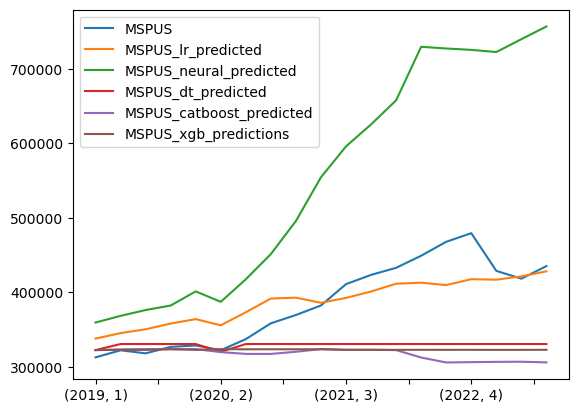

In [42]:
# Plot all predictions
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted', 'MSPUS_neural_predicted', 'MSPUS_dt_predicted', 'MSPUS_catboost_predicted', 'MSPUS_xgb_predictions']].plot()

# Possible Future Enhancements / Next Steps

1. **Data Analysis Without Time Series Structure:**
   - Consider resetting the index and exploring analytical approaches that do not rely on the time series structure. This could provide insights into patterns and trends that may be obscured by the current time-based indexing grouped by year and quarter.
   

2. **Resolve Time Series Indexing Conflicts:**
   - Investigate and implement a more robust approach to address time series indexing conflicts. Address issues such as inconsistent date indexing and irregular frequency reporting to enhance the reliability of your data.

3. **Deepen Understanding of Model Algorithms:**
   - Dive into the Python implementation of the chosen models to gain a deeper understanding of the underlying algorithms. This exploration can lead to better-informed model selection, parameter tuning, and overall improved model performance.
